# Getting info on Priming experiment dataset that's needed for modeling

## Info:

* __Which gradient(s) to simulate?__
* For each gradient to simulate:
  * Infer total richness of starting community 
  * Get distribution of total OTU abundances per fraction
    * Number of sequences per sample
  * Infer total abundance of each target taxon

# User variables

In [157]:
baseDir = '/home/nick/notebook/SIPSim/dev/priming_exp/'
workDir = os.path.join(baseDir, 'exp_info')

otuTableFile = '/var/seq_data/priming_exp/data/otu_table.txt'
otuTableSumFile = '/var/seq_data/priming_exp/data/otu_table_summary.txt'

metaDataFile = '/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt'

#otuRepFile = '/var/seq_data/priming_exp/otusn.pick.fasta'
#otuTaxFile = '/var/seq_data/priming_exp/otusn_tax/otusn_tax_assignments.txt'
#genomeDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/'

# Init

In [116]:
import glob

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(fitdistrplus)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid


In [36]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)

# Loading OTU table (filter to just bulk samples)

In [46]:
%%R -i otuTableFile

tbl = read.delim(otuTableFile, sep='\t')

# filter
tbl = tbl %>%
    select(ends_with('.NA'))

tbl %>% ncol %>% print
tbl[1:4,1:4]

[1] 70
  X00C.000.14.09.NA X13C.100.14.08.NA X12C.700.28.04.NA X13C.000.45.04.NA
1                60                88                54                69
2                 1                 0                 0                 0
3                 0                 0                 0                 0
4                 0                 0                 0                 0


In [47]:
%%R

tbl.h = tbl %>% 
    gather('sample', 'count', 1:ncol(tbl)) %>%
    separate(sample, c('isotope','treatment','day','rep','fraction'), sep='\\.', remove=F)
tbl.h %>% head    

             sample isotope treatment day rep fraction count
1 X00C.000.14.09.NA    X00C       000  14  09       NA    60
2 X00C.000.14.09.NA    X00C       000  14  09       NA     1
3 X00C.000.14.09.NA    X00C       000  14  09       NA     0
4 X00C.000.14.09.NA    X00C       000  14  09       NA     0
5 X00C.000.14.09.NA    X00C       000  14  09       NA     1
6 X00C.000.14.09.NA    X00C       000  14  09       NA     0


# Which gradient(s) to simulate?

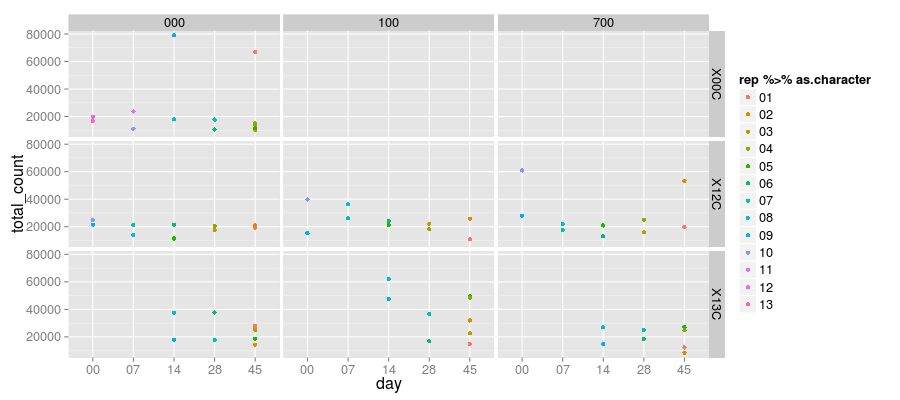

In [51]:
%%R -w 900 -h 400

tbl.h.s = tbl.h %>%
    group_by(sample) %>%
    summarize(total_count = sum(count)) %>%
    separate(sample, c('isotope','treatment','day','rep','fraction'), sep='\\.', remove=F)

ggplot(tbl.h.s, aes(day, total_count, color=rep %>% as.character)) +
    geom_point() +
    facet_grid(isotope ~ treatment) +
    theme(
        text = element_text(size=16)
        )

In [69]:
%%R
tbl.h.s$sample[grepl('700', tbl.h.s$sample)] %>% as.vector %>% sort

 [1] "X12C.700.00.09.NA" "X12C.700.00.10.NA" "X12C.700.07.07.NA"
 [4] "X12C.700.07.08.NA" "X12C.700.14.05.NA" "X12C.700.14.06.NA"
 [7] "X12C.700.28.03.NA" "X12C.700.28.04.NA" "X12C.700.45.01.NA"
[10] "X12C.700.45.02.NA" "X13C.700.14.08.NA" "X13C.700.14.09.NA"
[13] "X13C.700.28.06.NA" "X13C.700.28.07.NA" "X13C.700.45.01.NA"
[16] "X13C.700.45.02.NA" "X13C.700.45.03.NA" "X13C.700.45.04.NA"
[19] "X13C.700.45.05.NA"


#### Notes

Samples to simulate

* Isotope:
  * 12C vs 13C
* Treatment:
  * 700
* Days:
  * 14
  * 28
  * 45
 

In [73]:
%%R
# bulk soil samples for gradients to simulate

samples.to.use = c(
"X12C.700.14.05.NA",
"X12C.700.28.03.NA",
"X12C.700.45.01.NA",
"X13C.700.14.08.NA",
"X13C.700.28.06.NA",
"X13C.700.45.01.NA"
)

# Total richness of starting (bulk-soil) community

Method:

* Total number of OTUs in OTU table (i.e., gamma richness)
* Just looking at bulk soil samples

## Loading just bulk soil

In [56]:
%%R -i otuTableFile

tbl = read.delim(otuTableFile, sep='\t')

# filter
tbl = tbl %>%
    select(ends_with('.NA'))
tbl$OTUId = rownames(tbl)

tbl %>% ncol %>% print
tbl[1:4,1:4]

[1] 71
  X00C.000.14.09.NA X13C.100.14.08.NA X12C.700.28.04.NA X13C.000.45.04.NA
1                60                88                54                69
2                 1                 0                 0                 0
3                 0                 0                 0                 0
4                 0                 0                 0                 0


In [57]:
%%R

tbl.h = tbl %>% 
    gather('sample', 'count', 1:(ncol(tbl)-1)) %>%
    separate(sample, c('isotope','treatment','day','rep','fraction'), sep='\\.', remove=F)
tbl.h %>% head    

  OTUId            sample isotope treatment day rep fraction count
1     1 X00C.000.14.09.NA    X00C       000  14  09       NA    60
2     2 X00C.000.14.09.NA    X00C       000  14  09       NA     1
3     3 X00C.000.14.09.NA    X00C       000  14  09       NA     0
4     4 X00C.000.14.09.NA    X00C       000  14  09       NA     0
5     5 X00C.000.14.09.NA    X00C       000  14  09       NA     1
6     6 X00C.000.14.09.NA    X00C       000  14  09       NA     0


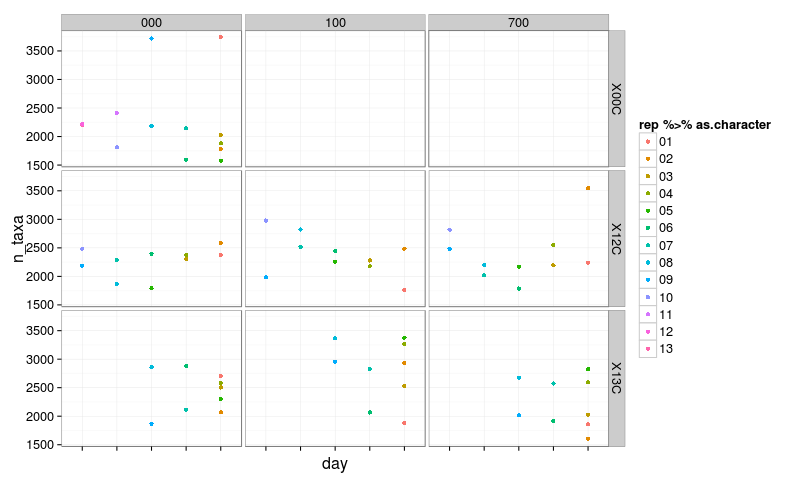

In [65]:
%%R -w 800
tbl.s = tbl.h %>% 
    filter(count > 0) %>%
    group_by(sample, isotope, treatment, day, rep, fraction) %>%
    summarize(n_taxa = n())

ggplot(tbl.s, aes(day, n_taxa, color=rep %>% as.character)) +
    geom_point() +
    facet_grid(isotope ~ treatment) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )

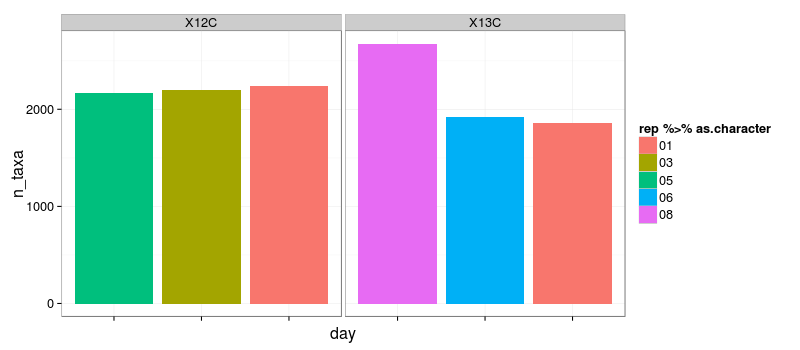

In [79]:
%%R -w 800 -h 350
# filter to just target samples

tbl.s.f = tbl.s %>% filter(sample %in% samples.to.use)

ggplot(tbl.s.f, aes(day, n_taxa, fill=rep %>% as.character)) +
    geom_bar(stat='identity') +
    facet_grid(. ~ isotope) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )

In [82]:
%%R
message('Bulk soil total observed richness: ')

tbl.s.f %>% select(-fraction) %>% as.data.frame %>% print

Bulk soil total observed richness: 
             sample isotope treatment day rep n_taxa
1 X13C.700.28.06.NA    X13C       700  28  06   1917
2 X13C.700.14.08.NA    X13C       700  14  08   2677
3 X12C.700.28.03.NA    X12C       700  28  03   2194
4 X12C.700.45.01.NA    X12C       700  45  01   2239
5 X12C.700.14.05.NA    X12C       700  14  05   2170
6 X13C.700.45.01.NA    X13C       700  45  01   1858


# Distribution of total sequences per fraction
  
* Number of sequences per sample
* Using all samples to assess this one
* Just fraction samples

Method:

* Total number of sequences (total abundance) per sample

### Loading OTU table

In [145]:
%%R -i otuTableFile

tbl = read.delim(otuTableFile, sep='\t')

# filter
tbl = tbl %>%
    select(-ends_with('.NA'))

tbl %>% ncol %>% print
tbl[1:4,1:4]

[1] 398
     OTUId X12C.700.45.01.24 X12C.700.14.06.14 X12C.100.14.05.18
1 OTU.4776               157                34                13
2 OTU.2864                 0                 1                 2
3 OTU.8170                 0                 0                 0
4 OTU.8762                 0                 0                 0


In [146]:
%%R

tbl.h = tbl %>% 
    gather('sample', 'count', 2:ncol(tbl)) %>%
    separate(sample, c('isotope','treatment','day','rep','fraction'), sep='\\.', remove=F)
tbl.h %>% head    

      OTUId            sample isotope treatment day rep fraction count
1  OTU.4776 X12C.700.45.01.24    X12C       700  45  01       24   157
2  OTU.2864 X12C.700.45.01.24    X12C       700  45  01       24     0
3  OTU.8170 X12C.700.45.01.24    X12C       700  45  01       24     0
4  OTU.8762 X12C.700.45.01.24    X12C       700  45  01       24     0
5  OTU.5223 X12C.700.45.01.24    X12C       700  45  01       24     0
6 OTU.13091 X12C.700.45.01.24    X12C       700  45  01       24     0


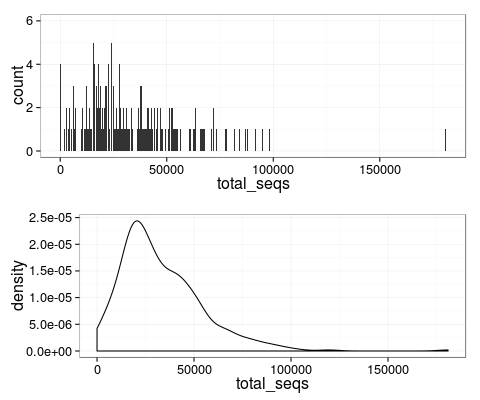

In [147]:
%%R -h 400

#tbl.s = apply(tbl, 2, sum) %>% as.data.frame
#colnames(tbl.s) = c('count')

#tbl.s %>% head

tbl.h.s = tbl.h %>%
    group_by(sample) %>%
    summarize(total_seqs = sum(count))


p = ggplot(tbl.h.s, aes(total_seqs)) +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )
p1 = p + geom_histogram(binwidth=200) 
p2 = p + geom_density()

grid.arrange(p1,p2,ncol=1)

### Distribution fitting

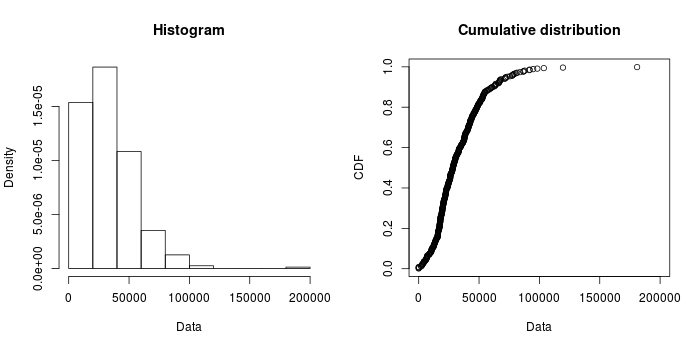

In [152]:
%%R -w 700 -h 350
plotdist(tbl.h.s$total_seqs)

summary statistics
------
min:  1   max:  180942 
median:  28263 
mean:  33211.14 
estimated sd:  21541.77 
estimated skewness:  1.627343 
estimated kurtosis:  8.871846 


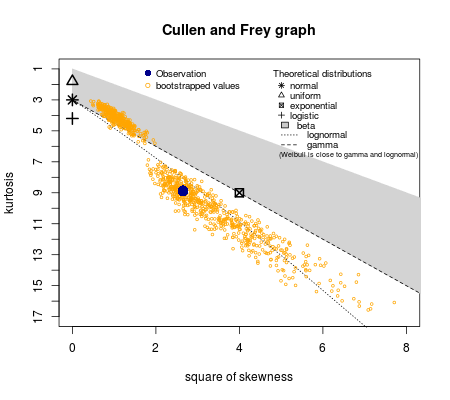

In [153]:
%%R -w 450 -h 400
descdist(tbl.h.s$total_seqs, boot=1000)

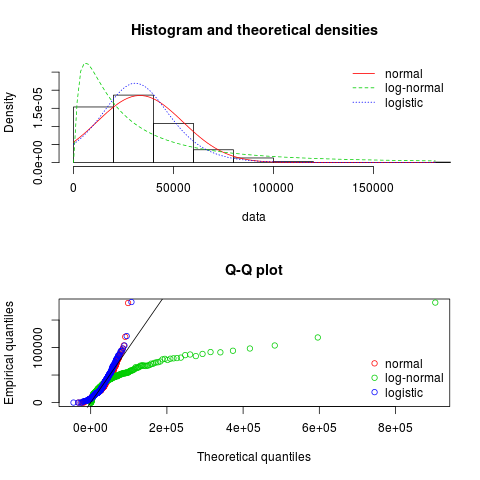

In [154]:
%%R
f.n = fitdist(tbl.h.s$total_seqs, 'norm')
f.ln = fitdist(tbl.h.s$total_seqs, 'lnorm')
f.ll = fitdist(tbl.h.s$total_seqs, 'logis')
#f.c = fitdist(tbl.s$count, 'cauchy')
f.list = list(f.n, f.ln, f.ll)

plot.legend = c('normal', 'log-normal', 'logistic')

par(mfrow = c(2,1))
denscomp(f.list, legendtext=plot.legend)
qqcomp(f.list, legendtext=plot.legend)

In [155]:
%%R

gofstat(list(f.n, f.ln, f.ll), fitnames=plot.legend)

Goodness-of-fit statistics
                                normal log-normal   logistic
Kolmogorov-Smirnov statistic 0.1010961  0.1971488 0.06645885
Cramer-von Mises statistic   1.2726290  4.4212031 0.58739094
Anderson-Darling statistic   7.5953687 26.8795505 4.84350229

Goodness-of-fit criteria
                                 normal log-normal logistic
Aikake's Information Criterion 9051.969   9300.198 9013.198
Bayesian Information Criterion 9059.937   9308.166 9021.166


In [156]:
%%R
summary(f.ln)

Fitting of the distribution ' lnorm ' by maximum likelihood 
Parameters : 
         estimate Std. Error
meanlog 10.113351 0.05983293
sdlog    1.192163 0.04230814
Loglikelihood:  -4648.099   AIC:  9300.198   BIC:  9308.166 
Correlation matrix:
        meanlog sdlog
meanlog       1     0
sdlog         0     1



#### Notes:

* best fit:
  * lognormal
    * mean = 10.113
    * sd = 1.192

## Does sample size correlate to buoyant density?

### Loading OTU table

In [201]:
%%R -i otuTableFile

tbl = read.delim(otuTableFile, sep='\t')

# filter
tbl = tbl %>%
    select(-ends_with('.NA')) %>%
    select(-starts_with('X0MC'))
tbl = tbl %>%
    gather('sample', 'count', 2:ncol(tbl)) %>%
    mutate(sample = gsub('^X', '', sample))

tbl %>% head

      OTUId           sample count
1  OTU.4776 12C.700.45.01.24   157
2  OTU.2864 12C.700.45.01.24     0
3  OTU.8170 12C.700.45.01.24     0
4  OTU.8762 12C.700.45.01.24     0
5  OTU.5223 12C.700.45.01.24     0
6 OTU.13091 12C.700.45.01.24     0


In [202]:
%%R
# summarize

tbl.s = tbl %>%
    group_by(sample) %>%
    summarize(total_count = sum(count))
tbl.s %>% head(n=3)

Source: local data frame [3 x 2]

            sample total_count
1 12C.000.14.05.01       21963
2 12C.000.14.05.02       94820
3 12C.000.14.05.03       25674


### Loading metadata

In [203]:
%%R -i metaDataFile

tbl.meta = read.delim(metaDataFile, sep='\t')
tbl.meta %>% head(n=3)

            Sample FractionNum Bulk Control CC X100 X700 H2O Day Density rep
1 12C.000.28.03.07           7    0       1  1    0    0   0  28  1.7646    
2 12C.000.28.03.08           8    0       1  1    0    0   0  28  1.7614    
3 12C.000.28.03.09           9    0       1  1    0    0   0  28  1.7537    
  contolVlabel Treatment
1      control    12C000
2      control    12C000
3      control    12C000


### Determining association

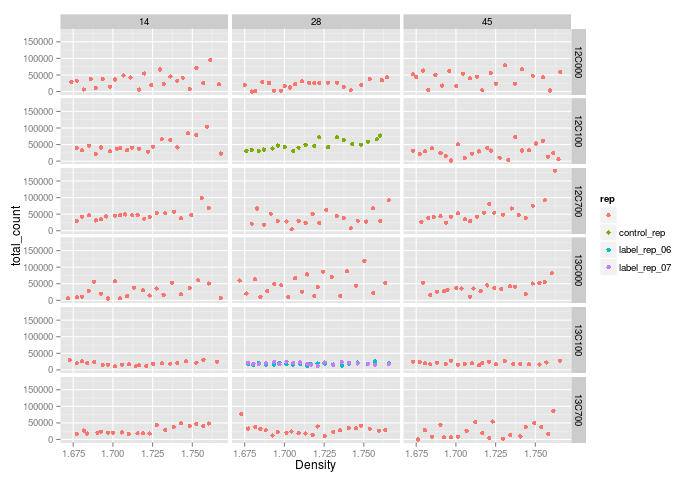

In [186]:
%%R -w 700

tbl.j = inner_join(tbl.s, tbl.meta, c('sample' = 'Sample')) 

ggplot(tbl.j, aes(Density, total_count, color=rep)) +
    geom_point() +
    facet_grid(Treatment ~ Day)

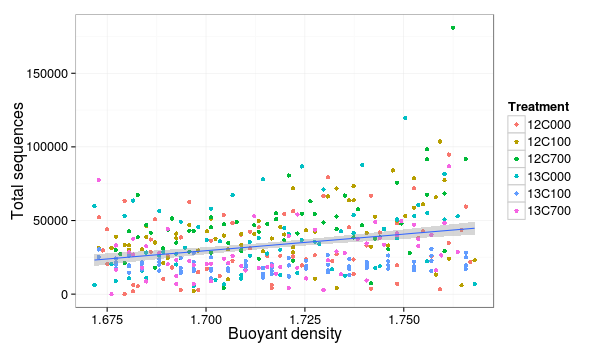

In [184]:
%%R -w 600 -h 350

ggplot(tbl.j, aes(Density, total_count)) +
    geom_point(aes(color=Treatment)) +
    geom_smooth(method='lm') +
    labs(x='Buoyant density', y='Total sequences') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

## Number of taxa along the gradient

In [204]:
%%R
tbl %>% head

      OTUId           sample count
1  OTU.4776 12C.700.45.01.24   157
2  OTU.2864 12C.700.45.01.24     0
3  OTU.8170 12C.700.45.01.24     0
4  OTU.8762 12C.700.45.01.24     0
5  OTU.5223 12C.700.45.01.24     0
6 OTU.13091 12C.700.45.01.24     0


In [208]:
%%R 

tbl.s = tbl %>%
    filter(count > 0) %>%
    group_by(sample) %>%
    summarize(n_taxa = sum(count > 0))

tbl.j = inner_join(tbl.s, tbl.meta, c('sample' = 'Sample')) 
tbl.j %>% head(n=3)

Source: local data frame [3 x 14]

            sample n_taxa FractionNum Bulk Control CC X100 X700 H2O Day Density
1 12C.000.14.05.01    526           1    0       1  1    0    0   0  14  1.7668
2 12C.000.14.05.02   3458           2    0       1  1    0    0   0  14  1.7614
3 12C.000.14.05.03   2493           3    0       1  1    0    0   0  14  1.7570
Variables not shown: rep (fctr), contolVlabel (fctr), Treatment (fctr)


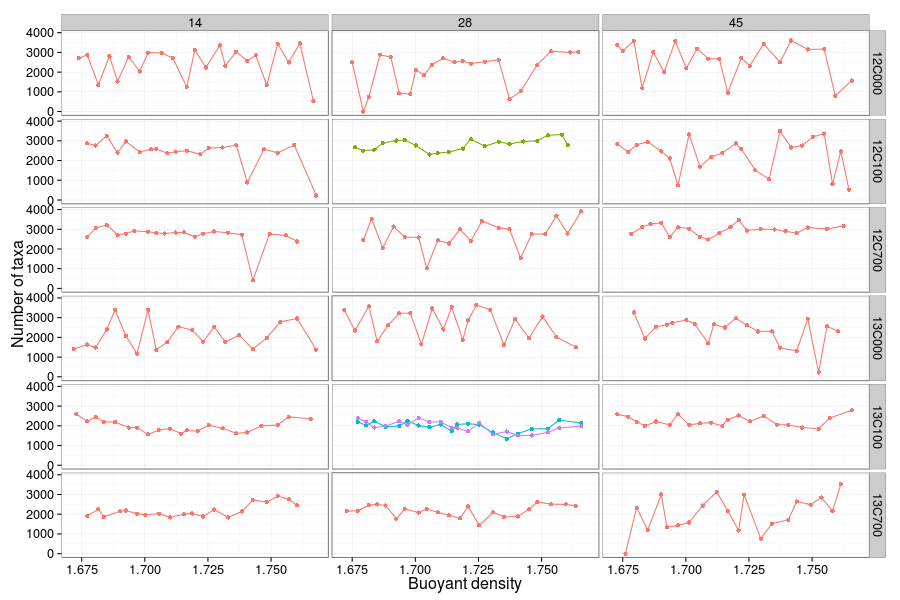

In [217]:
%%R -w 900 -h 600

ggplot(tbl.j, aes(Density, n_taxa, fill=rep, color=rep)) +
    #geom_area(stat='identity', alpha=0.5, position='dodge') +
    geom_point() +
    geom_line() +
    labs(x='Buoyant density', y='Number of taxa') +
    facet_grid(Treatment ~ Day) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )

#### Notes:

* Many taxa out to the tails of the gradient.
* It seems that the DNA fragments were quite diffuse in the gradients.

# Total abundance of each target taxon (relative abundance in pre-gradient community)


* Getting relative abundances from bulk soil samples


In [134]:
%%R -i otuTableFile

tbl = read.delim(otuTableFile, sep='\t')

# filter
tbl = tbl %>%
    select(matches('OTUId'), ends_with('.NA'))

tbl %>% ncol %>% print
tbl[1:4,1:4]

[1] 71
     OTUId X00C.000.14.09.NA X13C.100.14.08.NA X12C.700.28.04.NA
1 OTU.4776                60                88                54
2 OTU.2864                 1                 0                 0
3 OTU.8170                 0                 0                 0
4 OTU.8762                 0                 0                 0


In [135]:
%%R
# long table format w/ selecting samples of interest
tbl.h = tbl %>% 
    gather('sample', 'count', 2:ncol(tbl)) %>%
    separate(sample, c('isotope','treatment','day','rep','fraction'), sep='\\.', remove=F) %>%
    filter(sample %in% samples.to.use,
           count > 0) 
tbl.h %>% head    

      OTUId            sample isotope treatment day rep fraction count
1  OTU.4776 X13C.700.28.06.NA    X13C       700  28  06       NA    26
2   OTU.611 X13C.700.28.06.NA    X13C       700  28  06       NA     2
3   OTU.961 X13C.700.28.06.NA    X13C       700  28  06       NA     1
4   OTU.527 X13C.700.28.06.NA    X13C       700  28  06       NA     1
5 OTU.12349 X13C.700.28.06.NA    X13C       700  28  06       NA     1
6   OTU.262 X13C.700.28.06.NA    X13C       700  28  06       NA     9


In [136]:
%%R
message('Number of samples: ', tbl.h$sample %>% unique %>% length)
message('Number of OTUs: ', tbl.h$OTUId %>% unique %>% length)

Number of samples: 6
Number of OTUs: 4252


In [137]:
%%R

tbl.hs = tbl.h %>%
    group_by(OTUId) %>%
    summarize(
        total_count = sum(count),
        mean_count = mean(count),
        median_count = median(count),
        sd_count = sd(count)
    ) %>%
    filter(total_count > 0)

tbl.hs %>% head

Source: local data frame [6 x 5]

     OTUId total_count mean_count median_count    sd_count
1    OTU.1        1590  265.00000          187 173.4785289
2   OTU.10          80   13.33333           12   6.0553007
3  OTU.100         148   24.66667           22  15.7437818
4 OTU.1000           2    1.00000            1   0.0000000
5 OTU.1001           7    1.40000            1   0.5477226
6 OTU.1002          10    2.00000            2   0.7071068


### For each sample, writing a table of OTU_ID and count

In [140]:
%%R -i workDir
setwd(workDir)

samps = tbl.h$sample %>% unique %>% as.vector

for(samp in samps){
    outFile = paste(c(samp, 'OTU.txt'), collapse='_')
    
    tbl.p = tbl.h %>% 
        filter(sample == samp, count > 0)
    
    write.table(tbl.p, outFile, sep='\t', quote=F, row.names=F)
    
    message('Table written: ', outFile)
    message('  Number of OTUs: ', tbl.p %>% nrow)
    }

Table written: X13C.700.28.06.NA_OTU.txt
  Number of OTUs: 1917
Table written: X13C.700.14.08.NA_OTU.txt
  Number of OTUs: 2677
Table written: X12C.700.28.03.NA_OTU.txt
  Number of OTUs: 2194
Table written: X12C.700.45.01.NA_OTU.txt
  Number of OTUs: 2239
Table written: X12C.700.14.05.NA_OTU.txt
  Number of OTUs: 2170
Table written: X13C.700.45.01.NA_OTU.txt
  Number of OTUs: 1858


# Making directories for simulations

In [133]:
p = os.path.join(workDir, '*_OTU.txt')
files = glob.glob(p)

baseDir = os.path.split(workDir)[0]
newDirs = [os.path.split(x)[1].rstrip('.NA_OTU.txt') for x in files]
newDirs = [os.path.join(baseDir, x) for x in newDirs]

for newDir,f in zip(newDirs, files):
    if not os.path.isdir(newDir):
        print 'Making new directory: {}'.format(newDir)
        os.makedirs(newDir)
    else:
        print 'Directory exists: {}'.format(newDir)
    # symlinking file
    linkPath = os.path.join(newDir, os.path.split(f)[1])
    if not os.path.islink(linkPath):
        os.symlink(f, linkPath)

Directory exists: /home/nick/notebook/SIPSim/dev/priming_exp/X13C.700.28.06
Directory exists: /home/nick/notebook/SIPSim/dev/priming_exp/X12C.700.28.03
Directory exists: /home/nick/notebook/SIPSim/dev/priming_exp/X13C.700.14.08
Directory exists: /home/nick/notebook/SIPSim/dev/priming_exp/X13C.700.45.01
Directory exists: /home/nick/notebook/SIPSim/dev/priming_exp/X12C.700.45.01
Directory exists: /home/nick/notebook/SIPSim/dev/priming_exp/X12C.700.14.05


# OLD

In [4]:
%%R -i otuTableFile

tbl = read.delim(otuTableFile, sep='\t')

print('Number of samples: ')
print(ncol(tbl))

print('Number of OTUs: ')
print(nrow(tbl))

[1] "Number of samples: "
[1] 468
[1] "Number of OTUs: "
[1] 10361


In [21]:
%%R
# filtering

tbl.bulk = tbl %>% 
    select(matches('X00C'), OTUId)

print('Number of samples: ')
print(ncol(tbl.bulk))

print('Number of OTUs: ')
print(nrow(tbl.bulk))

[1] "Number of samples: "
[1] 14
[1] "Number of OTUs: "
[1] 10361


In [24]:
%%R

tbl.h = tbl.bulk %>% 
    gather('sample', 'count', 1:13)
tbl.h %>% head    

      OTUId            sample count
1  OTU.4776 X00C.000.14.09.NA    60
2  OTU.2864 X00C.000.14.09.NA     1
3  OTU.8170 X00C.000.14.09.NA     0
4  OTU.8762 X00C.000.14.09.NA     0
5  OTU.5223 X00C.000.14.09.NA     1
6 OTU.13091 X00C.000.14.09.NA     0


In [32]:
%%R

tbl.hs = tbl.h %>%
    group_by(OTUId) %>%
    summarize(
        total_count = sum(count),
        mean_count = mean(count),
        median_count = median(count),
        sd_count = sd(count)
    ) %>%
    filter(total_count > 0)

message('Number of samples: ', tbl.hs %>% ncol)
message('Number of OTUs: ', tbl.hs %>% distinct(OTUId) %>% nrow)

tbl.hs %>% head

Number of samples: 5
Number of OTUs: 5695
Source: local data frame [6 x 5]

      OTUId total_count   mean_count median_count    sd_count
1     OTU.1        2084 160.30769231           87 166.9971979
2    OTU.10          11   0.84615385            0   1.3445045
3   OTU.100         608  46.76923077           28  52.8001797
4  OTU.1000          13   1.00000000            1   1.2909944
5 OTU.10000           1   0.07692308            0   0.2773501
6  OTU.1001          12   0.92307692            0   1.9348358


In [37]:
%%R -i workDir
setwd(workDir)

outFile = 'bulk_OTU_abund_stats.txt'

write.table(tbl.hs, outFile, sep='\t', quote=F, row.names=F)